In [6]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Jan 15 09:09:34 2021

@author: dariograna

Reference: Grana and de Figueiredo, 2021, SeReMpy - Equations 5 and 6
"""

'\nCreated on Fri Jan 15 09:09:34 2021\n\n@author: dariograna\n\nReference: Grana and de Figueiredo, 2021, SeReMpy - Equations 5 and 6\n'

In [10]:
#Load library
import sys
sys.path.append('/workspaces/SeReMpy/Applications')
sys.path.append('/workspaces/SeReMpy/Data')

In [11]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
from scipy import signal
import numpy as np
from numpy import matlib

from context import SeReMpy
from SeReMpy.Inversion import *

In [17]:
#% Application4
# Load data (seismic data and time)
x = np.loadtxt('/workspaces/SeReMpy/Data/1Ddatalog.dat')
Rho = x[:,4].reshape(-1, 1)
Time = x[:,6].reshape(-1, 1)
Vp = x[:,7].reshape(-1, 1)
Vs = x[:,8].reshape(-1, 1)
s= np.loadtxt('/workspaces/SeReMpy/Data/1Ddataseis.dat')
Sfar = s[:,0].reshape(-1, 1)
Smid = s[:,1].reshape(-1, 1)
Snear = s[:,2].reshape(-1, 1)
TimeSeis = s[:,3].reshape(-1, 1)

#% Initial parameters
# number of samples (elastic properties)
nm = Snear.shape[0]+1
# number of variables
nv = 3
# reflection angles 
theta = np.linspace(15,45,3)
ntheta = len(theta)
# time sampling
dt = TimeSeis[1] - TimeSeis[0]
# error variance
varerr = 10 ** -4
sigmaerr = varerr * np.eye(ntheta * (nm - 1))

#% Wavelet
# wavelet 
freq = 45
ntw = 64
wavelet, tw = RickerWavelet(freq, dt, ntw)

#% Prior model (filtered well logs)
nfilt = 3
cutofffr = 0.04
b, a = signal.butter(nfilt, cutofffr)
Vpprior = signal.filtfilt(b, a, np.squeeze(Vp))
Vsprior = signal.filtfilt(b, a, np.squeeze(Vs))
Rhoprior = signal.filtfilt(b, a, np.squeeze(Rho))

#% Spatial correlation matrix
corrlength = 5 * dt
trow = np.matlib.repmat(np.arange(0, nm * dt, dt), nm, 1)
tcol = np.matlib.repmat(trow[0,:].reshape(nm,1), 1, nm)
tdis = abs(trow - tcol)
sigmatime = np.exp(-(tdis / corrlength) ** 2)
sigma0 = np.cov(np.hstack([np.log(Vp), np.log(Vs), np.log(Rho)]).T)
sigmaprior = np.kron(sigma0, sigmatime)

#% Seismic inversion
Seis = np.vstack([Snear, Smid, Sfar])
mmap, mlp, mup, t = SeismicInversion(Seis, TimeSeis, Vpprior, Vsprior, Rhoprior, sigmaprior, sigmaerr, wavelet, theta, nv)

Vpmap = mmap[0:nm,0]
Vsmap = mmap[nm:2*nm,0]
Rhomap = mmap[2*nm :,0]
Vplp = mlp[0:nm,0]
Vslp = mlp[nm:2*nm,0]
Rholp = mlp[2*nm:,0]
Vpup = mup[0:nm,0]
Vsup = mup[nm:2*nm,0]
Rhoup = mup[2*nm:,0]

/tmp/ipykernel_12968/3209131706.py:44: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  trow = np.matlib.repmat(np.arange(0, nm * dt, dt), nm, 1)


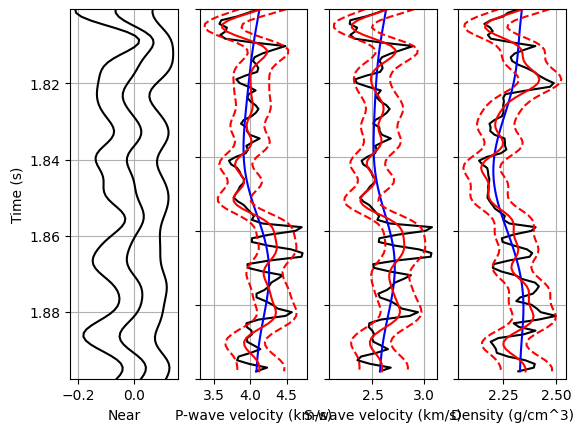

In [18]:
#% Plot data and results
plt.figure(1)
ax = plt.subplot(141)
plt.plot(Snear-0.1, TimeSeis, 'k')
plt.plot(Smid, TimeSeis, 'k')
plt.plot(Sfar+0.1, TimeSeis, 'k')
plt.grid()
plt.ylim(max(TimeSeis),min(TimeSeis))
plt.xlabel('Near')
plt.ylabel('Time (s)')
ax = plt.subplot(142)
plt.plot(Vp, Time, 'k')
plt.plot(Vpprior, Time, 'b')
plt.plot(Vpmap, Time, 'r')
plt.plot(Vplp, Time, 'r--')
plt.plot(Vpup, Time, 'r--')
plt.grid()
plt.ylim(max(Time),min(Time))
plt.xlabel('P-wave velocity (km/s)')
yticks = ax.get_yticks() 
ax.set_yticks(yticks) 
ax.set_yticklabels([])
ax = plt.subplot(143)
plt.plot(Vs, Time, 'k')
plt.plot(Vsprior, Time, 'b')
plt.plot(Vsmap, Time, 'r')
plt.plot(Vslp, Time, 'r--')
plt.plot(Vsup, Time, 'r--')
plt.grid()
plt.ylim(max(Time),min(Time))
plt.xlabel('S-wave velocity (km/s)')
ax.set_yticks(yticks) 
ax.set_yticklabels([])
ax = plt.subplot(144)
plt.plot(Rho, Time, 'k')
plt.plot(Rhoprior, Time, 'b')
plt.plot(Rhomap, Time, 'r')
plt.plot(Rholp, Time, 'r--')
plt.plot(Rhoup, Time, 'r--')
plt.grid()
plt.ylim(max(Time),min(Time))
plt.xlabel('Density (g/cm^3)')
ax.set_yticks(yticks) 
ax.set_yticklabels([])
plt.show()
